The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


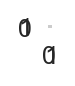

In [296]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [48]:
FIGPATH='/Users/riwa/Documents/admin/Copenhagen/DTU_PhD/THESIS/latex/images/'

ROC AUC: 0.93


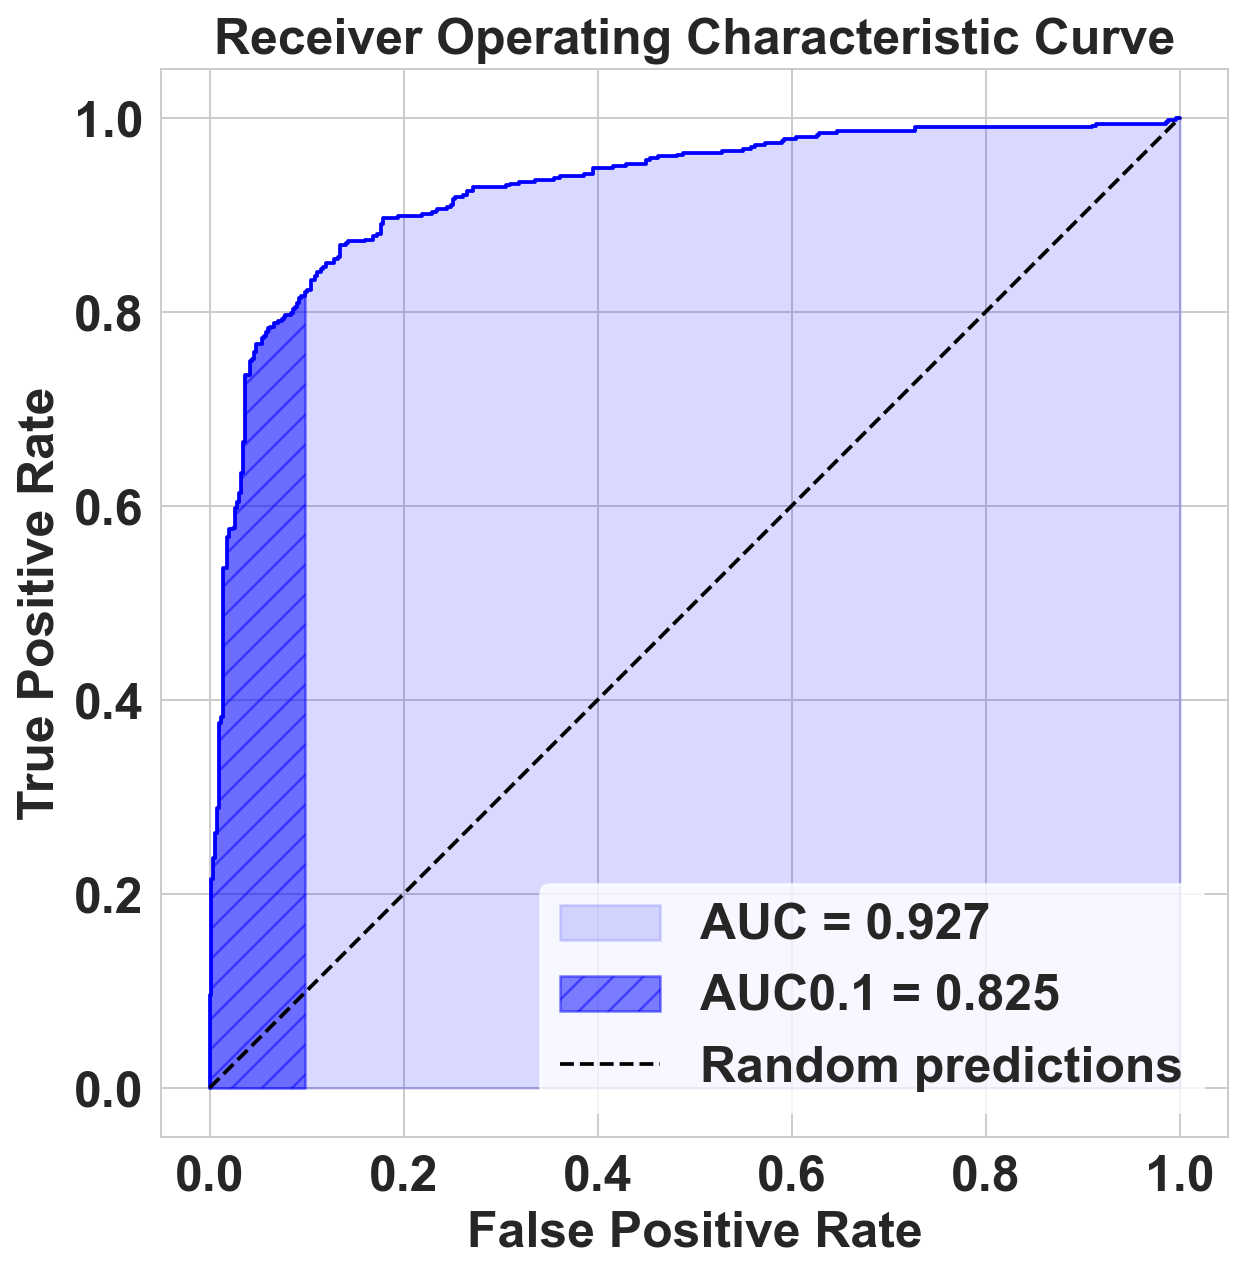

Average Precision (AP): 0.93


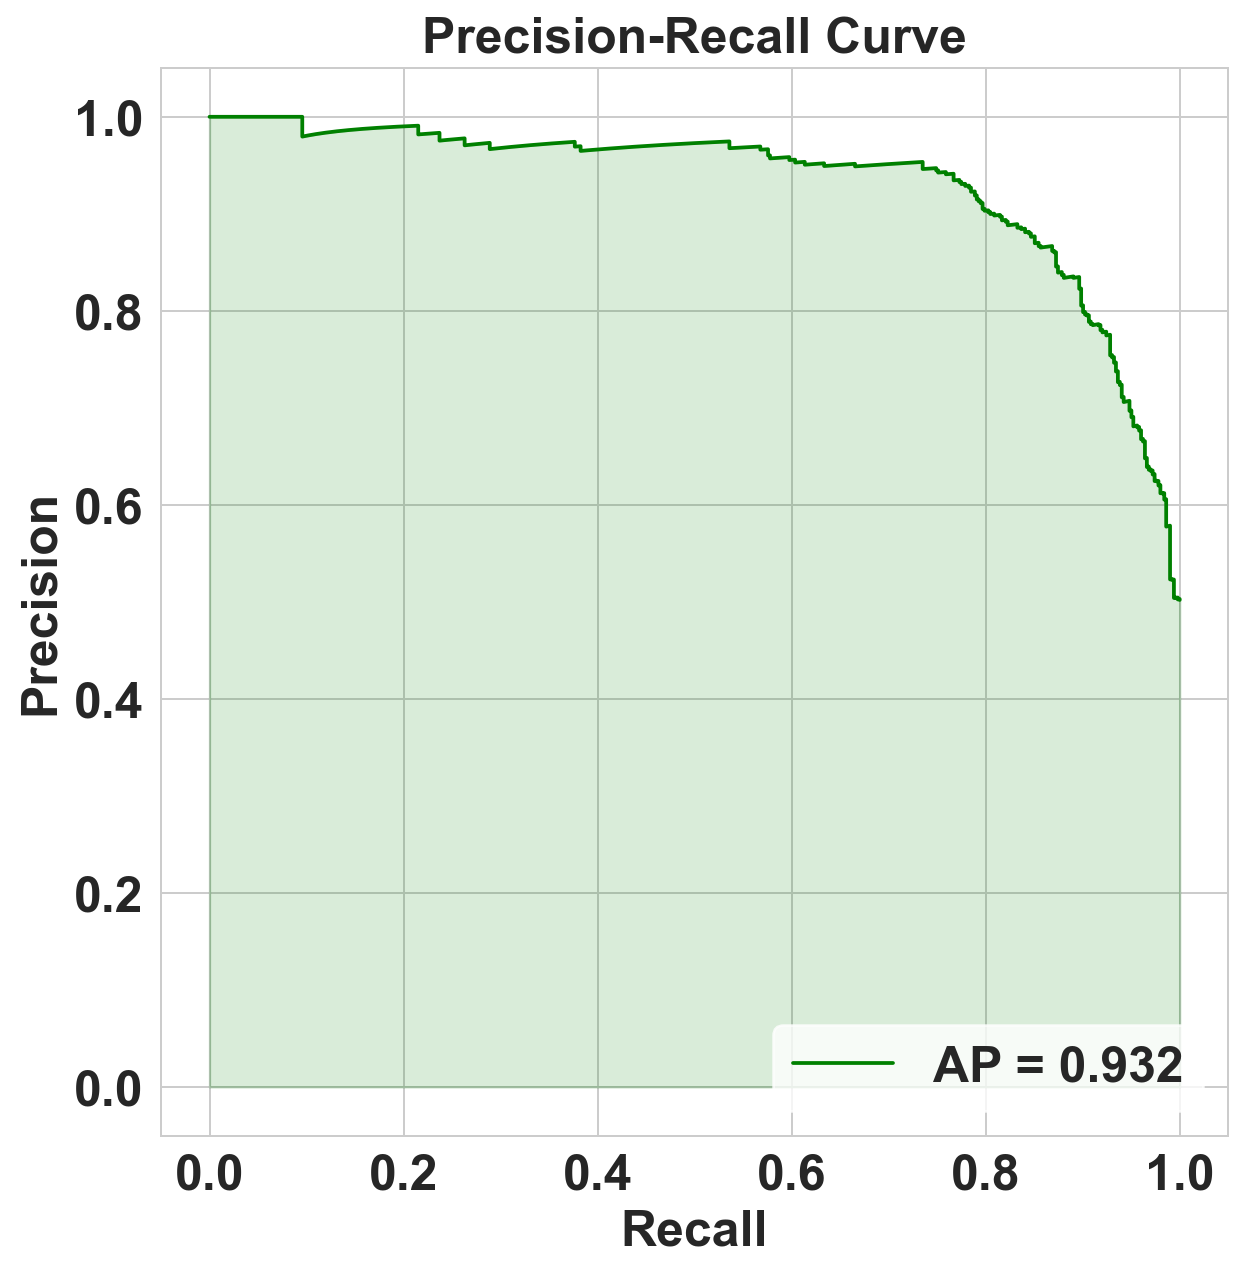

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
sns.set_style('whitegrid')
# Generate synthetic binary classification data.
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2,
                           n_redundant=10, n_clusters_per_class=1, flip_y=0.1,
                           random_state=42)
fw, fs = 'semibold', 20
# Train a logistic regression model.
clf = LogisticRegression(solver='liblinear')
clf.fit(X, y)
y_scores = clf.predict_proba(X)[:, 1]

# Calculate ROC curve and ROC AUC.
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
auc01 = roc_auc_score(y, y_scores, max_fpr=0.1)
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC curve with filled area.
fig,ax = plt.subplots(1,1, figsize=(7.7,7.7))
plt.plot(fpr, tpr, color='blue')
plt.fill_between(fpr, tpr, alpha=0.15, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.fill_between(fpr, tpr, where=(fpr<=0.1), alpha=0.5, color='blue', hatch='//',label=f'AUC0.1 = {auc01:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random predictions')
plt.xlabel('False Positive Rate', fontweight=fw, fontsize=fs)
plt.ylabel('True Positive Rate', fontweight=fw, fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
plt.title('Receiver Operating Characteristic Curve', fontweight=fw, fontsize=fs)
plt.legend(loc="lower right", prop={'weight':fw, 'size':fs},  edgecolor='w')
plt.axis('square')  # Make the plot square.
fig.savefig('/Users/riwa/Documents/admin/Copenhagen/DTU_PhD/THESIS/latex/images/ROCCURVE.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate Precision-Recall curve and Average Precision.
precision, recall, _ = precision_recall_curve(y, y_scores)
avg_precision = average_precision_score(y, y_scores)
print(f"Average Precision (AP): {avg_precision:.2f}")

# Plot Precision-Recall curve with filled area.
fig,ax = plt.subplots(1,1, figsize=(7.7,7.7))
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}', color='green')
plt.fill_between(recall, precision, alpha=0.15, color='green')
plt.xlabel('Recall', fontweight=fw, fontsize=fs)
plt.ylabel('Precision', fontweight=fw, fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
plt.title('Precision-Recall Curve', fontweight=fw, fontsize=fs)
plt.legend(loc="lower right", prop={'weight':fw, 'size':fs},  edgecolor='w')
fig.savefig('/Users/riwa/Documents/admin/Copenhagen/DTU_PhD/THESIS/latex/images/PRCURVE.png', dpi=300, bbox_inches='tight')
plt.axis('square')  # Make the plot square.
plt.show()

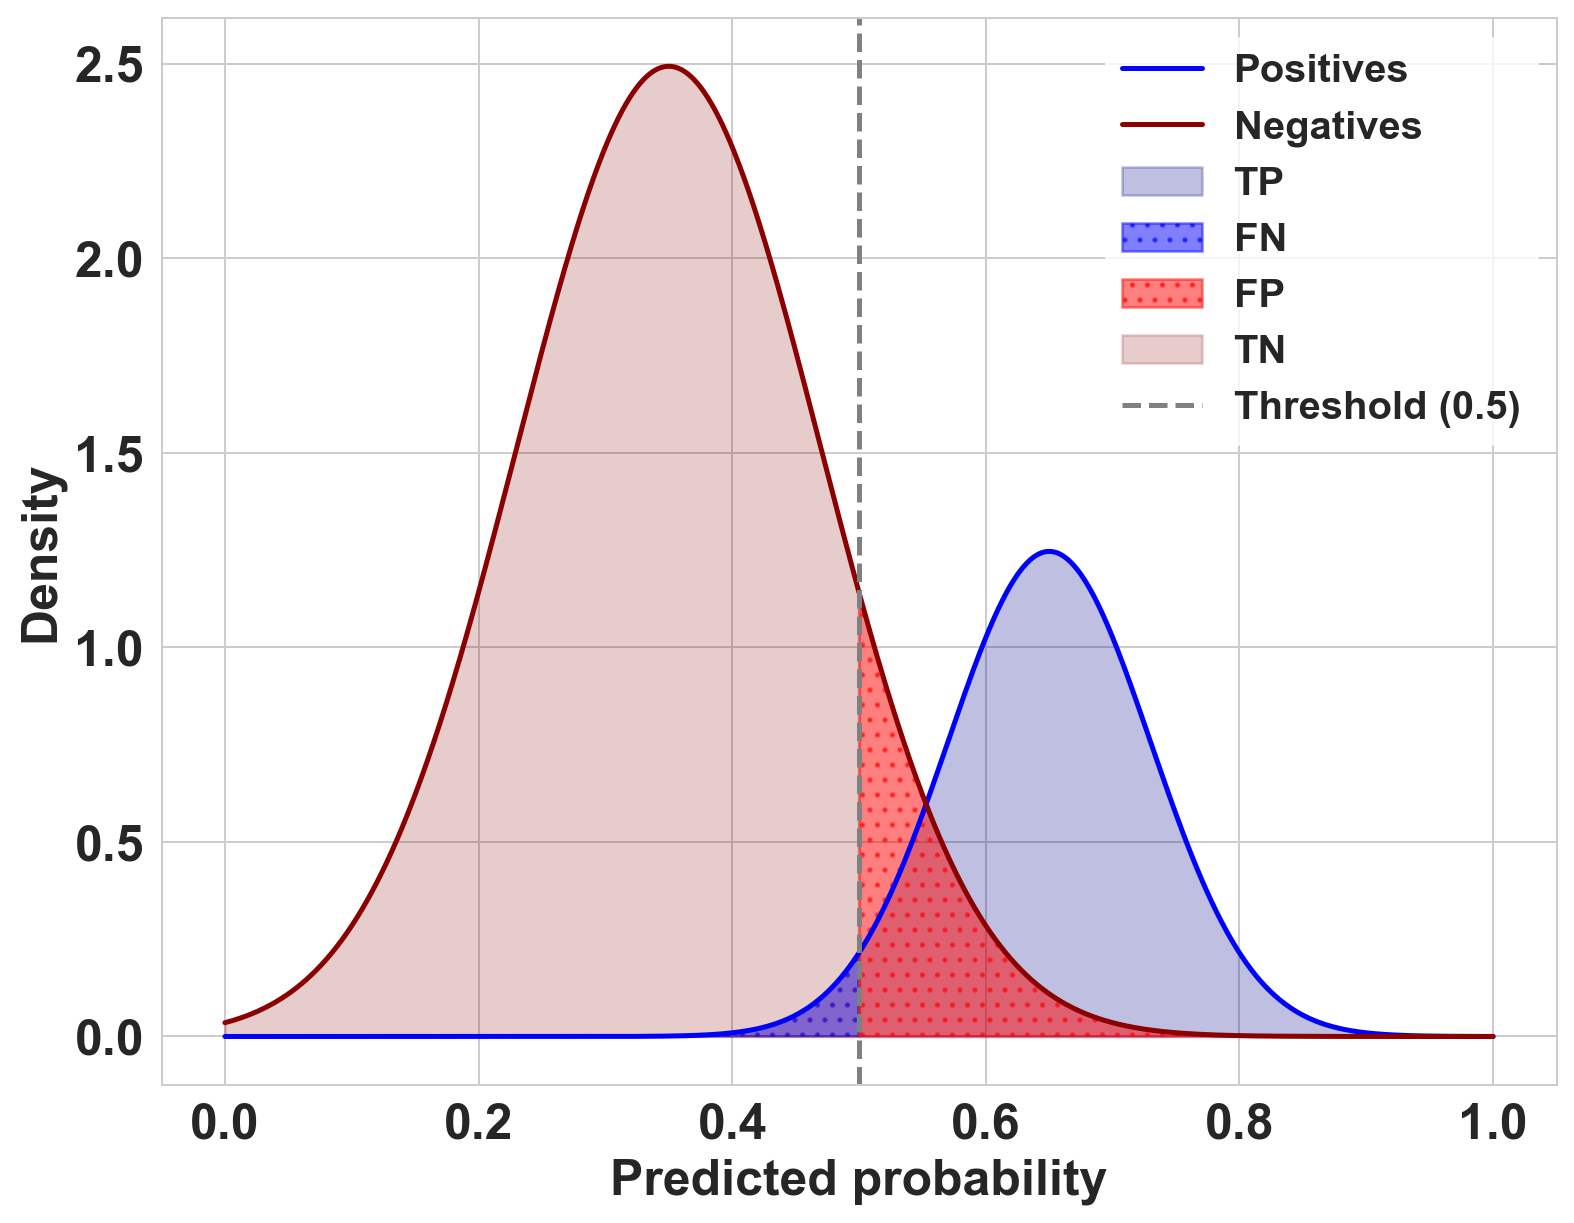

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate x values
x = np.linspace(0, 1, 1000)
# fs= fs -
# Define distributions with updated parameters
mu_pos, sigma_pos = 0.65, 0.08    # Positive distribution: shifted to the right, smaller sigma
mu_neg, sigma_neg = 0.35, 0.12   # Negative distribution: shifted to the left, larger sigma

# Compute densities with 3:1 ratio (3 negatives for every 1 positive)
pos_density = norm.pdf(x, mu_pos, sigma_pos) / 4    # 1/4 of the total area for positives
neg_density = norm.pdf(x, mu_neg, sigma_neg) * 3 / 4  # 3/4 of the total area for negatives

# Decision thresholds
thresholds = [.5]#.40, .50, .60]

# Create figure
fig,ax = plt.subplots(1,1, figsize=(10, 7.7))

# Plot density curves
plt.plot(x, pos_density, color='blue', lw=2, label='Positives')
plt.plot(x, neg_density, color='darkred', lw=2, label='Negatives')

# Choose the middle threshold for shading regions (e.g., 50)
threshold = thresholds[0]
plt.fill_between(x, 0, pos_density, where=(x >= threshold), color='darkblue', alpha=0.25, label="TP")
plt.fill_between(x, 0, pos_density, where=(x < threshold), color='blue', alpha=0.5, label="FN", hatch='..')
plt.fill_between(x, 0, neg_density, where=(x >= threshold), color='red', alpha=0.5, label="FP", hatch='..')
plt.fill_between(x, 0, neg_density, where=(x < threshold), color='darkred', alpha=0.2, label="TN")

# Add threshold lines
for t in thresholds:
    plt.axvline(t, color='gray', linestyle='dashed', linewidth=2, label='Threshold (0.5)')

# Labels and legend
ax.set_xlabel("Predicted probability", fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
ax.set_ylabel("Density", fontweight=fw, fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)

ax.legend(loc="upper right", prop={'weight':fw, 'size':fs-4},  edgecolor='w')
fig.savefig('/Users/riwa/Documents/admin/Copenhagen/DTU_PhD/THESIS/latex/images/predictions_proba.png', dpi=300, bbox_inches='tight')


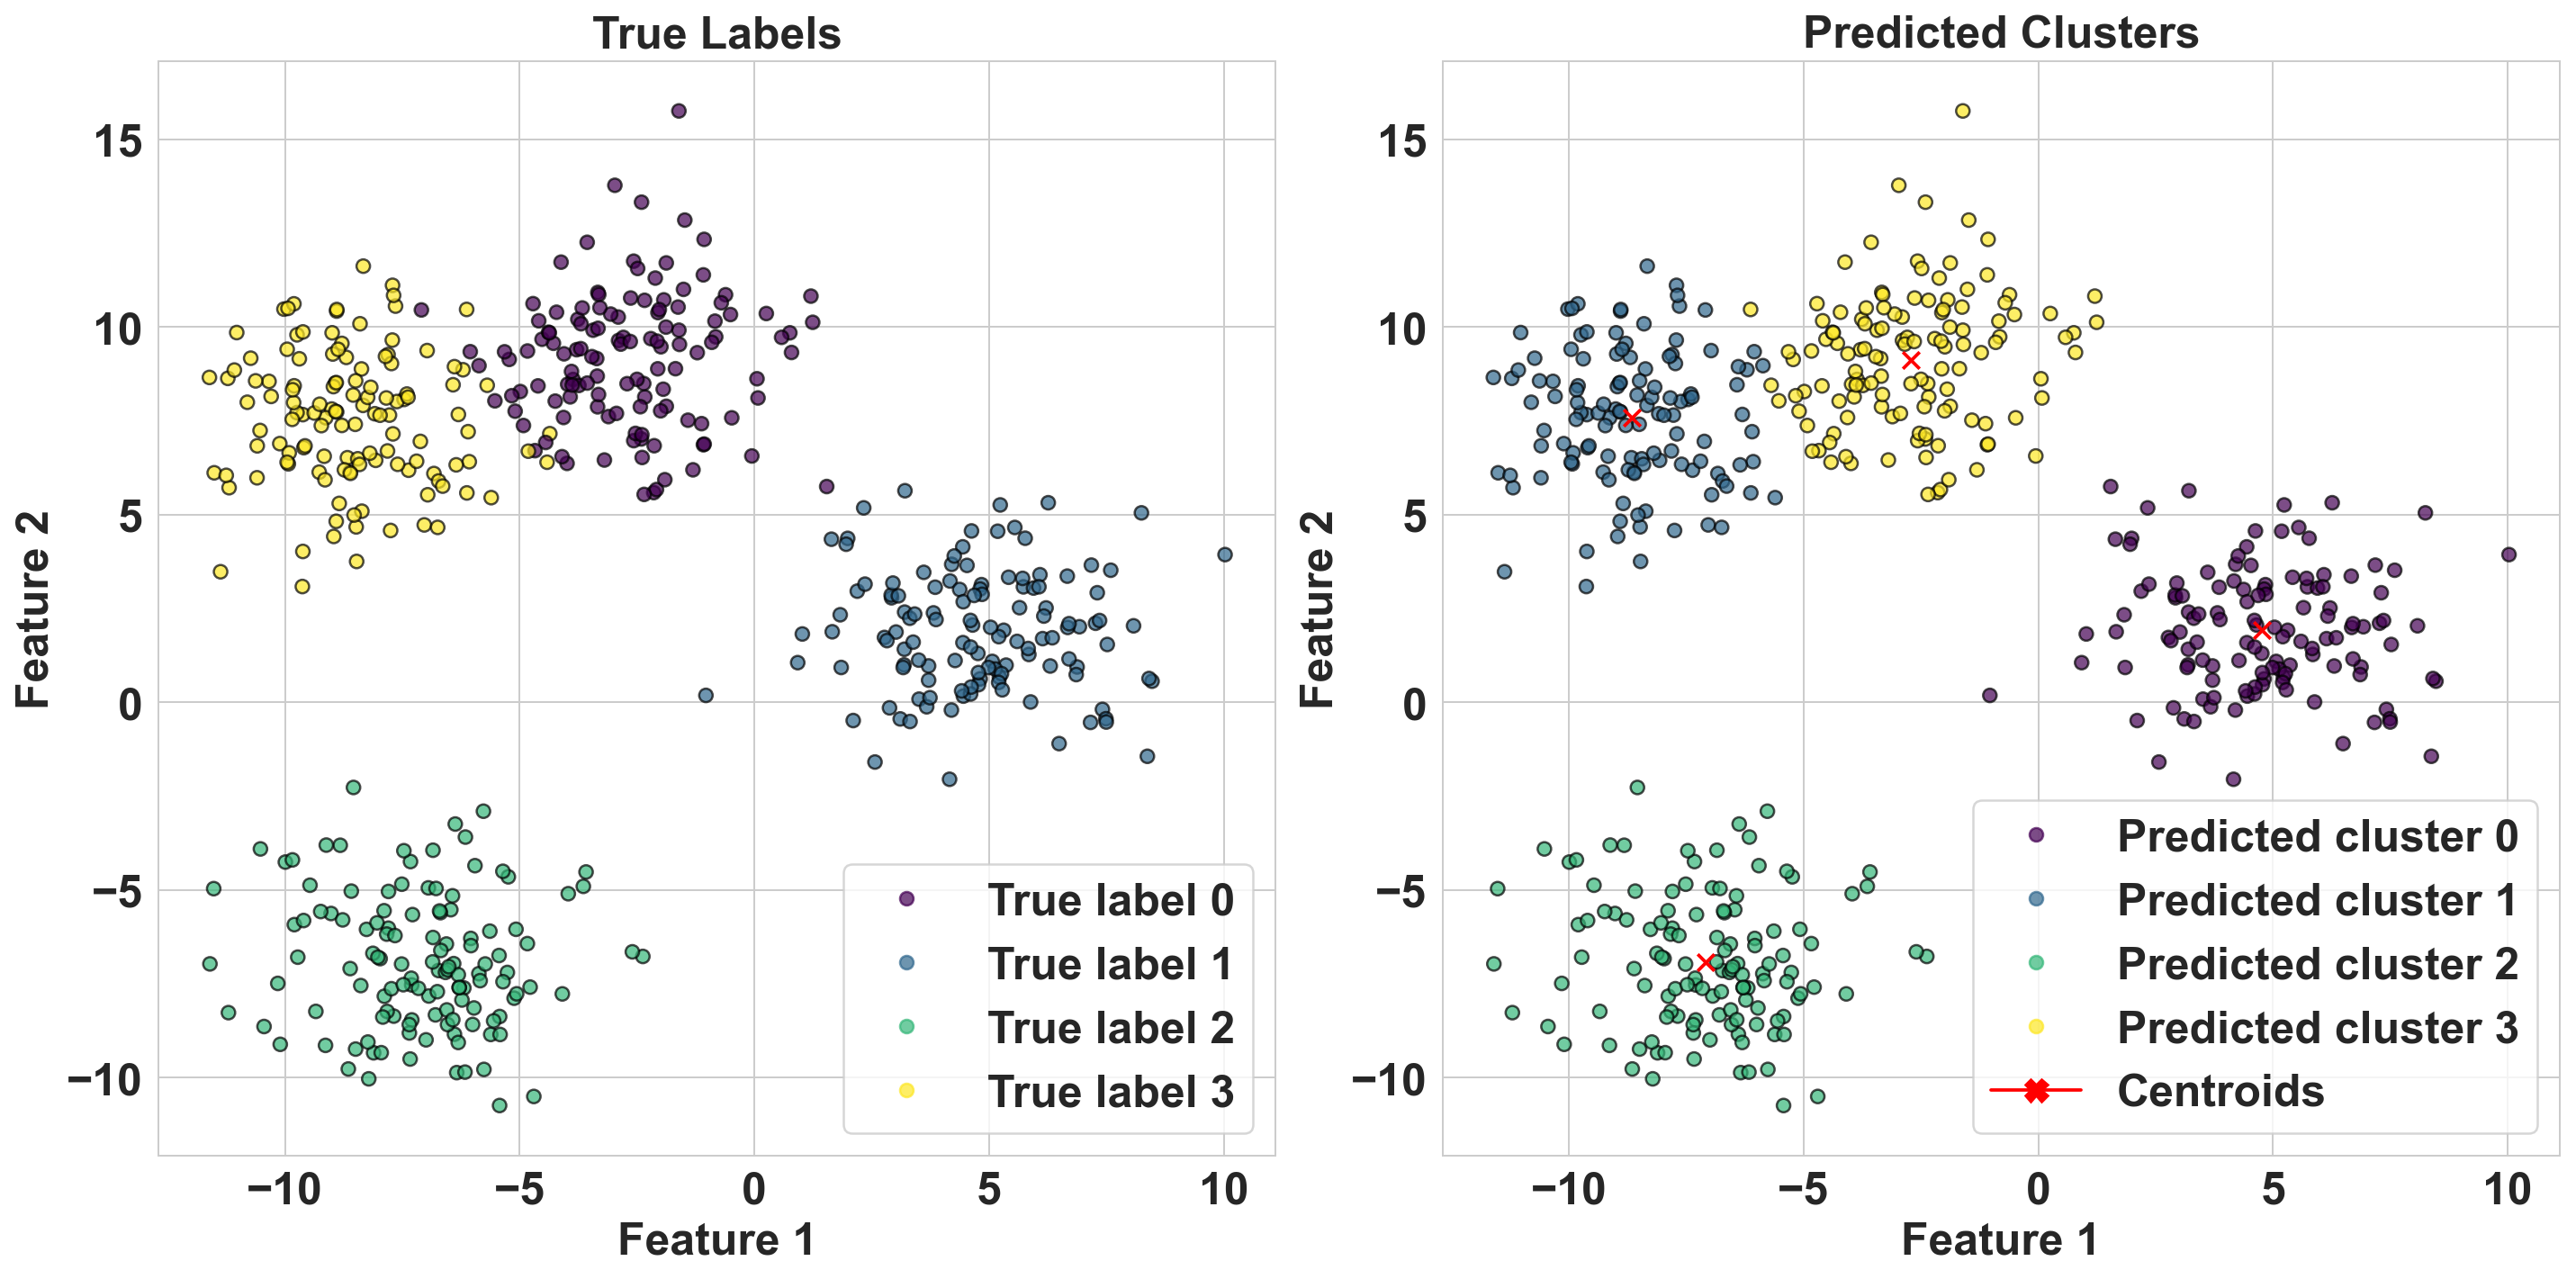

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic data with 3 clusters
n_samples = 500
ncl=4
X, y_true = make_blobs(n_samples=n_samples, centers=ncl, cluster_std=1.75, random_state=42)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=ncl, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

# Create figure for true labels and predicted clusters
fig, ax = plt.subplots(1,2, figsize=(8*2, 8))

# Plot True Labels
scatter_true = ax[0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolor='k', alpha=0.7)
ax[0].set_title("True Labels", fontweight=fw, fontsize=fs)
ax[0].set_xlabel("Feature 1", fontweight=fw, fontsize=fs)
ax[0].set_ylabel("Feature 2", fontweight=fw, fontsize=fs)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontweight=fw, fontsize=fs)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontweight=fw, fontsize=fs)
legend_labels = [f"True label {i}" for i in range(ncl)]
ax[0].legend(handles=scatter_true.legend_elements()[0], labels=legend_labels, prop={'weight':fw, 'size':fs}, loc='lower right')
# Plot Predicted Clusters
scatter_pred = plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', edgecolor='k', alpha=0.7)
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=55, label='Centroids')
ax[1].set_title("Predicted Clusters", fontweight=fw, fontsize=fs)
ax[1].set_xlabel("Feature 1", fontweight=fw, fontsize=fs)
ax[1].set_ylabel("Feature 2", fontweight=fw, fontsize=fs)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontweight=fw, fontsize=fs)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontweight=fw, fontsize=fs)
ax[1].legend()
legend_labels = [f"Predicted cluster {i}" for i in range(ncl)]
plt.legend(handles=scatter_pred.legend_elements()[0] + [plt.Line2D([0], [0], marker='X', color='red', markersize=10, label='Centroids')],
           labels=legend_labels + ['Centroids'], prop={'weight':fw, 'size':fs}, loc='lower right')

plt.tight_layout()
plt.show()

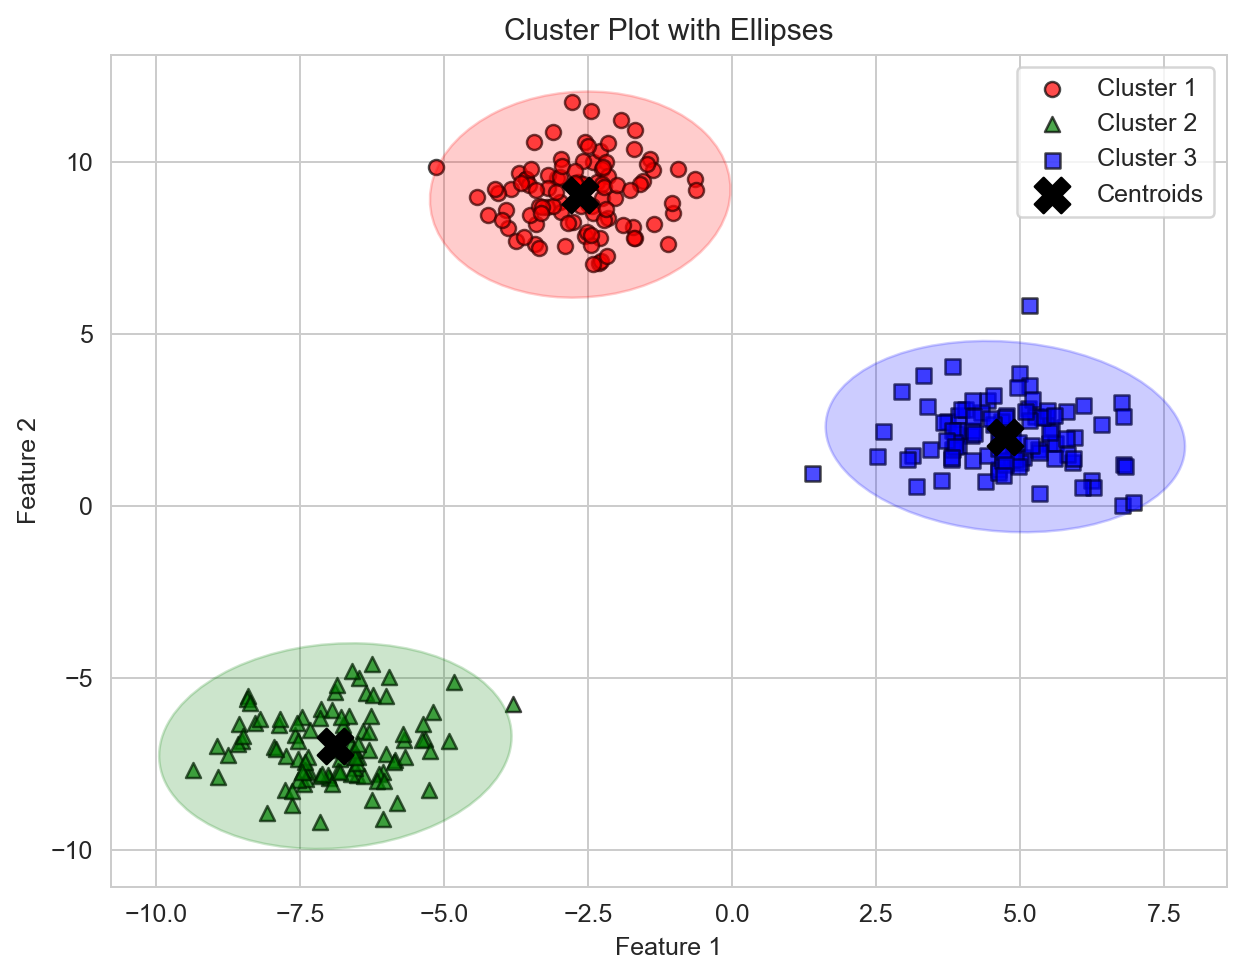

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# Generate synthetic data with 3 clusters
n_samples = 300
X, y_true = make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=42)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

# Define colors and markers
colors = ['red', 'green', 'blue']
markers = ['o', '^', 's']

# Create figure
plt.figure(figsize=(8, 6))

# Plot each cluster with different color, marker, and an ellipse
for cluster in range(3):
    cluster_points = X[y_pred == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster], marker=markers[cluster], edgecolor='k', alpha=0.7, label=f'Cluster {cluster+1}')
    
    # Compute ellipse parameters
    mean = np.mean(cluster_points, axis=0)
    cov = np.cov(cluster_points.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Width and height are 2 standard deviations
    width, height = 6 * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Add ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[cluster], facecolor=colors[cluster], alpha=0.2, linestyle='solid')
    plt.gca().add_patch(ellipse)

# Plot cluster centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')

# Labels and legend
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Cluster Plot with Ellipses")
plt.show()

In [79]:
pal=np.array([x for x in sns.color_palette('tab10', 4)])
pal

array([[0.12156863, 0.46666667, 0.70588235],
       [1.        , 0.49803922, 0.05490196],
       [0.17254902, 0.62745098, 0.17254902],
       [0.83921569, 0.15294118, 0.15686275]])

6
4.5
6
4.5


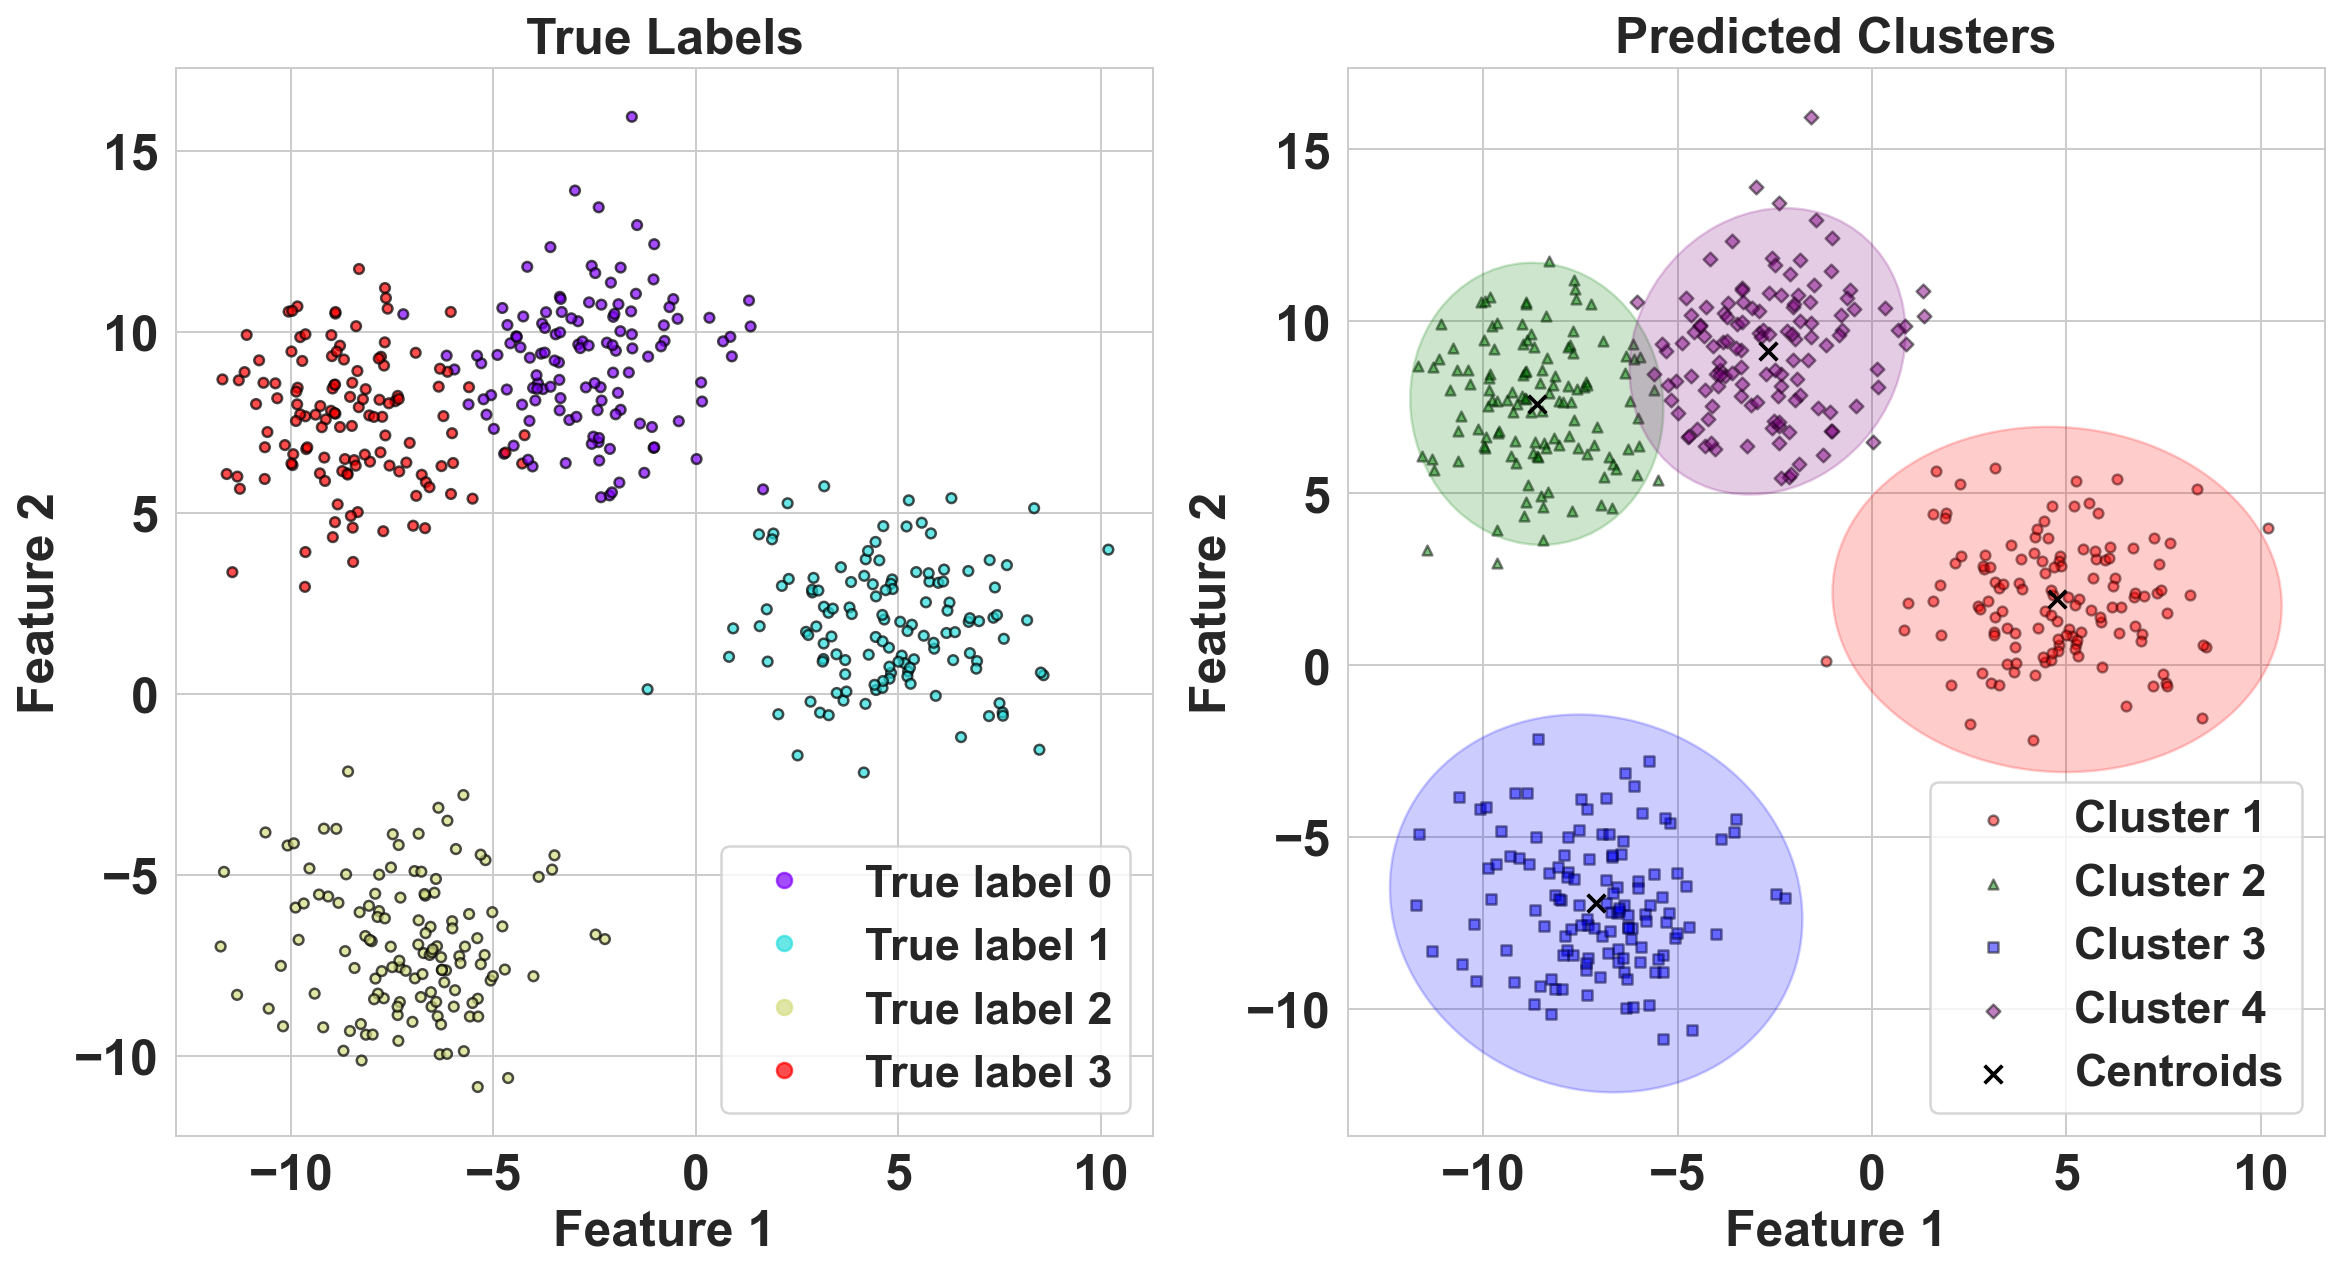

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# Generate synthetic data with 4 clusters
n_samples = 500
ncl = 4
X, y_true = make_blobs(n_samples=n_samples, centers=ncl, cluster_std=1.8, random_state=42)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=ncl, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

# Define colors and markers
colors = ['red', 'green', 'blue', 'purple']
# colors = [x for x in sns.color_palette('Pastel1')]
markers = ['o', '^', 's', 'D']

# marker_cmap = [colors[k] for k in y_true}
# Create figure for true labels and predicted clusters
fig, ax = plt.subplots(1, 2, figsize=(7.7 * 2, 7.7))

# Plot True Labels
scatter_true = ax[0].scatter(X[:, 0], X[:, 1], c=y_true, cmap='rainbow', edgecolor='k', alpha=0.7, s=15)
ax[0].set_title("True Labels", fontweight=fw, fontsize=fs)
ax[0].set_xlabel("Feature 1", fontweight=fw, fontsize=fs)
ax[0].set_ylabel("Feature 2", fontweight=fw, fontsize=fs)
legend_labels = [f"True label {i}" for i in range(ncl)]
ax[0].legend(handles=scatter_true.legend_elements()[0], labels=legend_labels, loc='lower right', prop={'weight':fw, 'size':fs-2})

# Plot Predicted Clusters with Ellipses
for cluster in range(ncl):
    cluster_points = X[y_pred == cluster]
    ax[1].scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster], 
                  marker=markers[cluster], edgecolor='k', alpha=0.5, s=15, label=f'Cluster {cluster+1}')
    
    # Compute ellipse parameters
    mean = np.mean(cluster_points, axis=0)
    cov = np.cov(cluster_points.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Width and height are 2 standard deviations
    kf = 4.5 if cluster in [1,3] else 6
    print(kf)
    width, height = kf * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Add ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[cluster], facecolor=colors[cluster], alpha=0.2, linestyle='solid')
    ax[1].add_patch(ellipse)

# Plot cluster centroids
ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=50, label='Centroids')
ax[1].set_title("Predicted Clusters", fontweight=fw, fontsize=fs)
ax[1].set_xlabel("Feature 1", fontweight=fw, fontsize=fs)
ax[1].set_ylabel("Feature 2", fontweight=fw, fontsize=fs)
ax[1].legend(prop={'weight':fw, 'size':fs-2})

ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=fs, fontweight=fw)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=fs, fontweight=fw)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=fs, fontweight=fw)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=fs, fontweight=fw)
fig.savefig(f'{FIGPATH}clusters_viz.png', dpi=300, bbox_inches='tight')

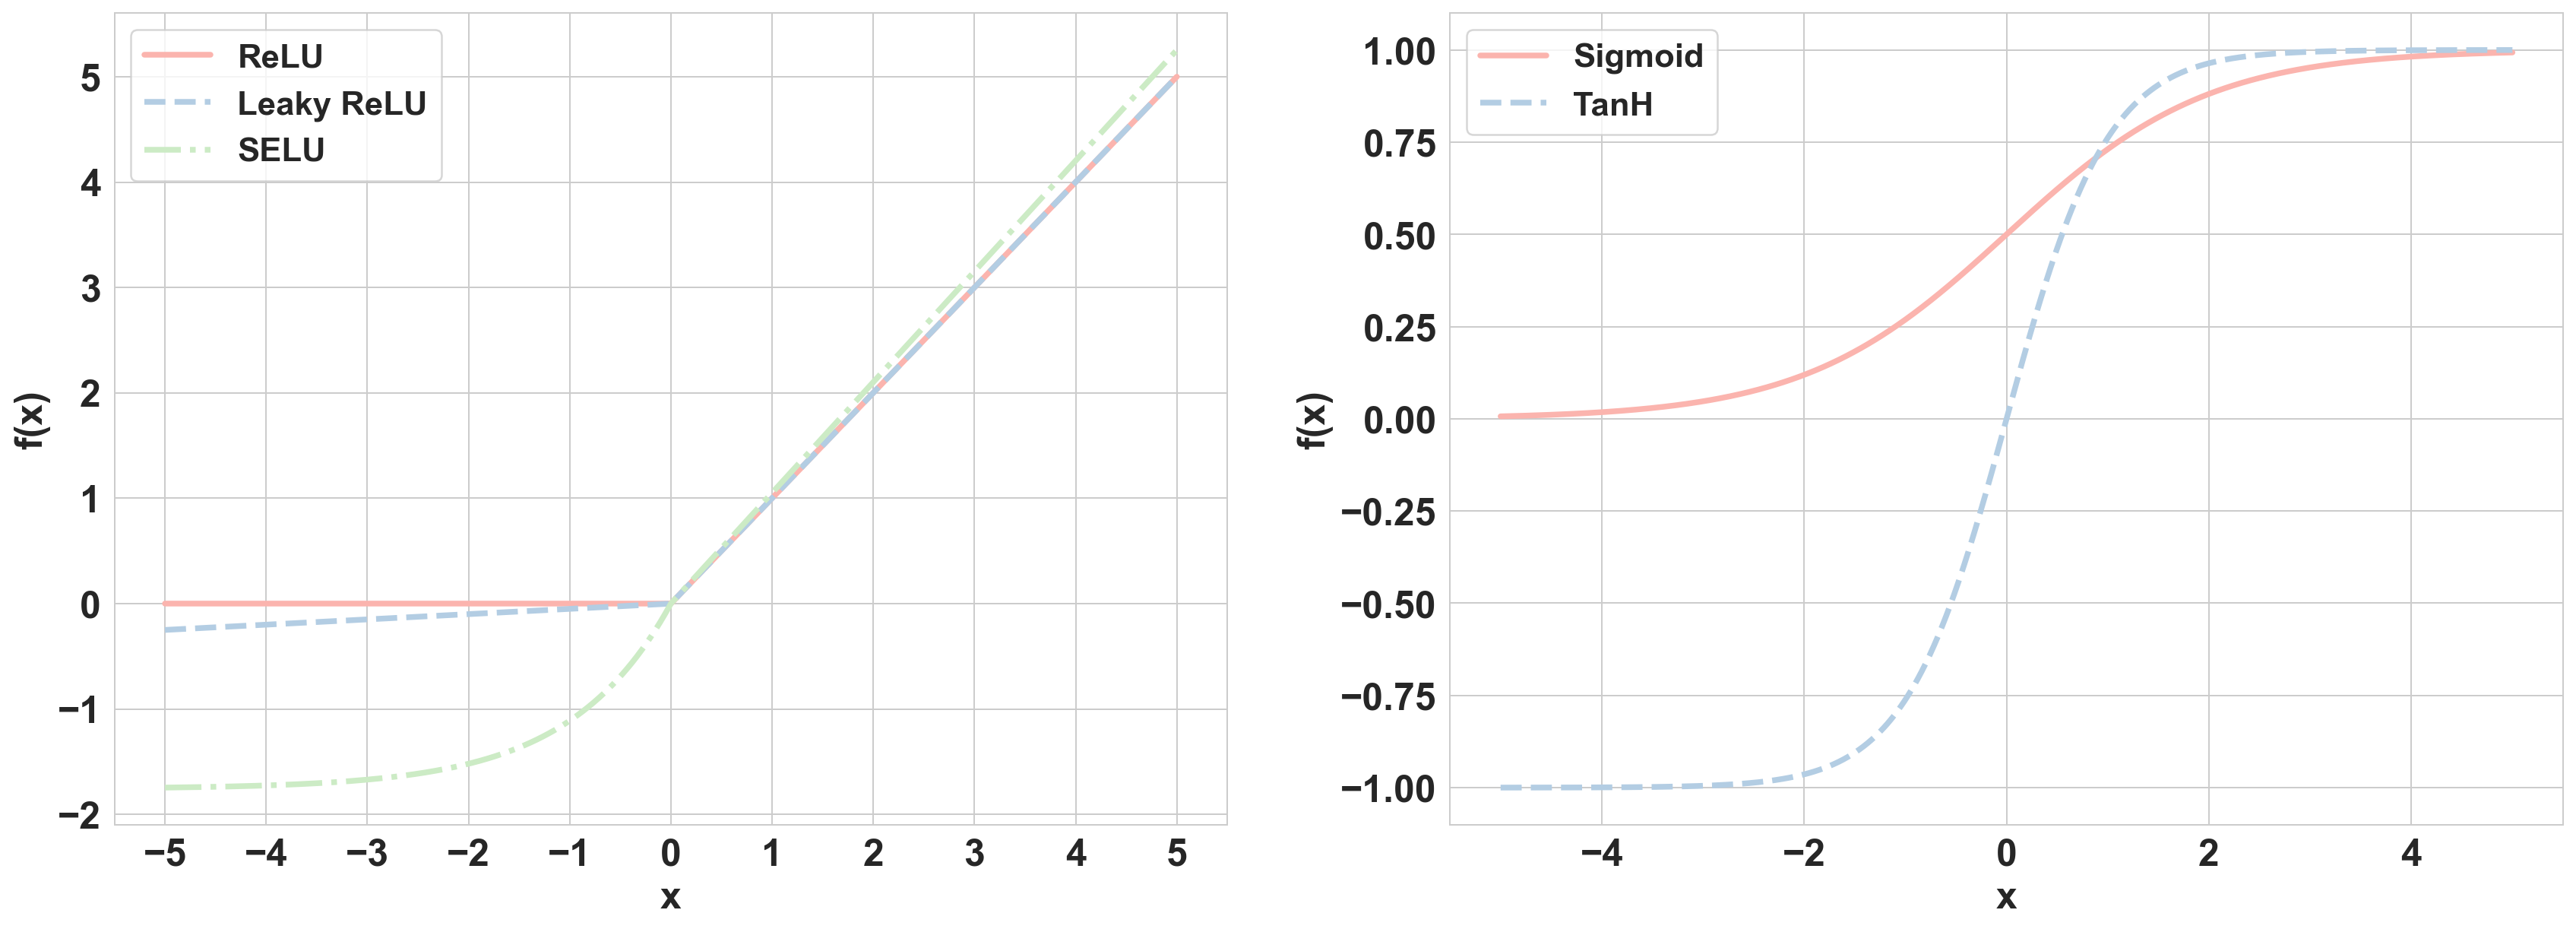

In [131]:
sns.set_palette('Pastel1')
fig,ax = plt.subplots(1,2, figsize=(15*7.7/5, 7.7))
x = torch.linspace(-5, 5, 1500)
ax[0].plot(x, F.relu(x), label='ReLU', lw=3, ls='-')
ax[0].plot(x, F.leaky_relu(x, 0.05), label='Leaky ReLU', lw=3, ls='--')
ax[0].plot(x, F.selu(x), label='SELU', lw=3, ls='-.')
ax[0].set_xticks(np.arange(-5, 6, 1))
ax[0].legend(loc='upper left', prop={'weight':fw, 'size':fs-2.5})
ax[1].plot(x, F.sigmoid(x), label='Sigmoid', lw=3, ls='-')
ax[1].plot(x, F.tanh(x), label='TanH', lw=3, ls='--')
ax[1].legend(loc='upper left', prop={'weight':fw, 'size':fs-2.5})
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontweight=fw, fontsize=fs)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontweight=fw, fontsize=fs)
ax[0].set_xlabel('x', fontweight=fw, fontsize=fs)
ax[0].set_ylabel('f(x)', fontweight=fw, fontsize=fs)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontweight=fw, fontsize=fs)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontweight=fw, fontsize=fs)
ax[1].set_xlabel('x', fontweight=fw, fontsize=fs)
ax[1].set_ylabel('f(x)', fontweight=fw, fontsize=fs)
fig.savefig(f'{FIGPATH}activations.png', bbox_inches='tight', dpi=300)

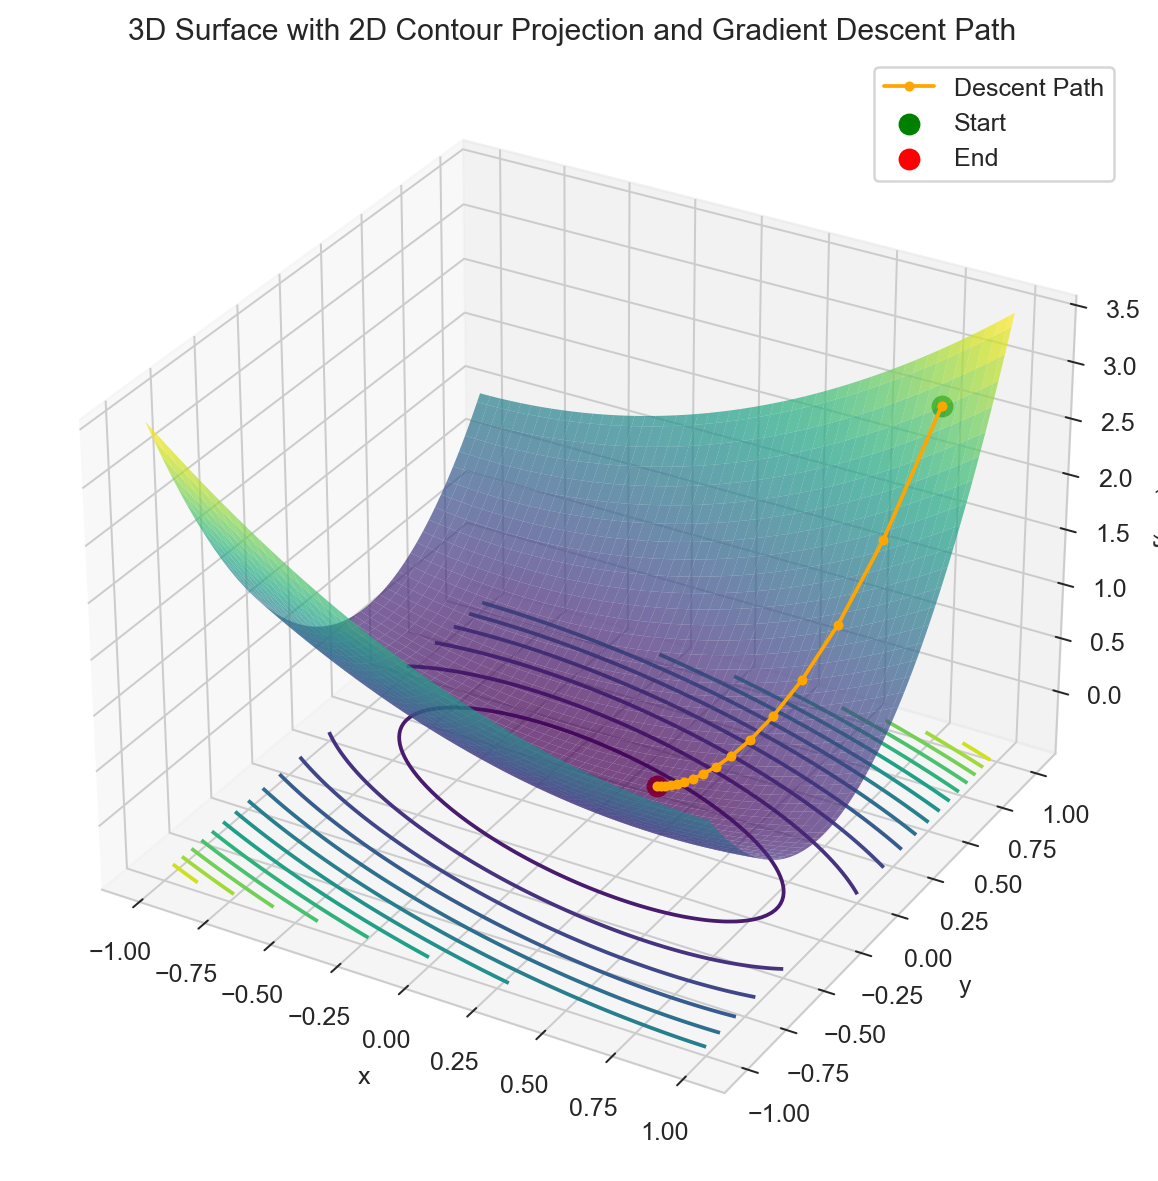

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Define a 2D function f(x,y) and its gradient
#    (This example uses a slightly "tilted" quadratic form
#     so that the descent path is not a simple straight line.)
# -------------------------------
def f(x, y):
    """
    A 'tilted bowl'-like function in two variables.
    """
    return 0.5*x**2 + 2.0*y**2 + x*y

def grad_f(x, y):
    """
    Gradient of f(x, y):
    df/dx = x + y
    df/dy = 4y + x
    """
    df_dx = x + y
    df_dy = 4.0*y + x
    return df_dx, df_dy

# -------------------------------
# 2) Perform Gradient Descent
# -------------------------------
learning_rate = 0.05
num_steps = 15
start = np.array([0.8, 0.9])  # Initial point

path = [start]
x_current, y_current = start

for _ in range(num_steps):
    dfdx, dfdy = grad_f(x_current, y_current)
    x_current -= learning_rate * dfdx
    y_current -= learning_rate * dfdy
    path.append([x_current, y_current])

path = np.array(path)
path_x, path_y = path[:, 0], path[:, 1]
path_z = f(path_x, path_y)

# -------------------------------
# 3) Create a 2D grid to plot the surface and contours
# -------------------------------
grid_points = 100
x_vals = np.linspace(-1, 1, grid_points)
y_vals = np.linspace(-1, 1, grid_points)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)

# -------------------------------
# 4) Plot the 3D surface, contour, and the descent path
# -------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# --- Plot the surface ---
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, edgecolor='none')

# --- Project contour onto a plane below the surface ---
z_offset = Z.min() - 0.5  # shift slightly below the lowest point of the surface
contours = ax.contour(
    X, Y, Z, 15, zdir='z', offset=z_offset, cmap='viridis'
)

# --- Plot the gradient descent path in 3D ---
ax.plot(path_x, path_y, path_z, 'ro-', label='Descent Path', color='orange', ms=3, zorder=10)

# Mark the starting and ending points distinctly
ax.scatter(path_x[0], path_y[0], path_z[0], color='green', s=60, label='Start')
ax.scatter(path_x[-1], path_y[-1], path_z[-1], color='red', s=60, label='End')

# --- Set axes limits & labels ---
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_zlim(z_offset, Z.max())

ax.set_title("3D Surface with 2D Contour Projection and Gradient Descent Path")
ax.legend()

plt.show()

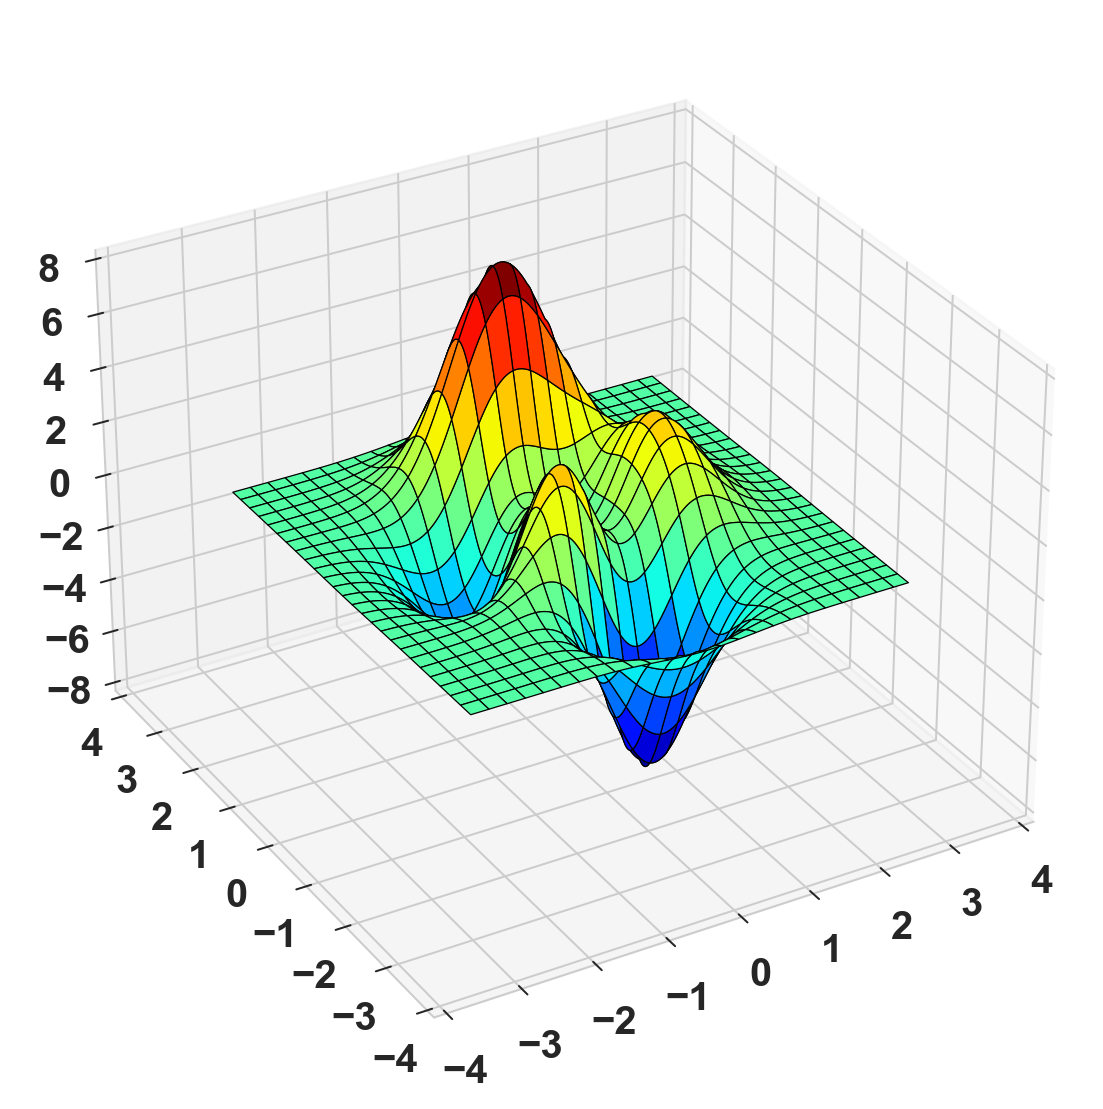

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the "peaks" function (same shape as MATLAB's peaks).
def peaks(x, y):
    """
    Returns the value of the 'peaks' function at (x, y).
    This function produces multiple peaks and valleys.
    """
    return (3 * (1 - x)**2 * np.exp(-x**2 - (y+1)**2)
            - 10 * (x/5 - x**3 - y**5) * np.exp(-x**2 - y**2)
            - 1/3 * np.exp(-(x+1)**2 - y**2))

# 2) Create a grid of points in the range [-3, 3] for both x and y.
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = peaks(X, Y)

# 3) Plot the surface in 3D with a wireframe look.
fig = plt.figure(figsize=(15,7.7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using a stride to show grid lines clearly.
surf = ax.plot_surface(
    X, Y, Z,
    rstride=8, cstride=8,       # controls the wireframe density
    cmap='jet',                 # colour map similar to older MATLAB style
    edgecolor='k', linewidth=0.5
)

# # 4) Adjust axes and labels.
# ax.set_xlabel("X", fontweight=fw, fontsize=fs)
# ax.set_ylabel("Y", fontweight=fw, fontsize=fs)
# ax.set_zlabel("Z", fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs-4)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs-4)
ax.set_zticklabels(ax.get_zticklabels(), fontweight=fw, fontsize=fs-4)

# Set axis limits to match the reference image's approximate range.
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-8, 8)
ax.view_init(elev=30, azim=-120)
fig.savefig(f'{FIGPATH}3D_gradient_map.png', dpi=300, bbox_inches='tight')

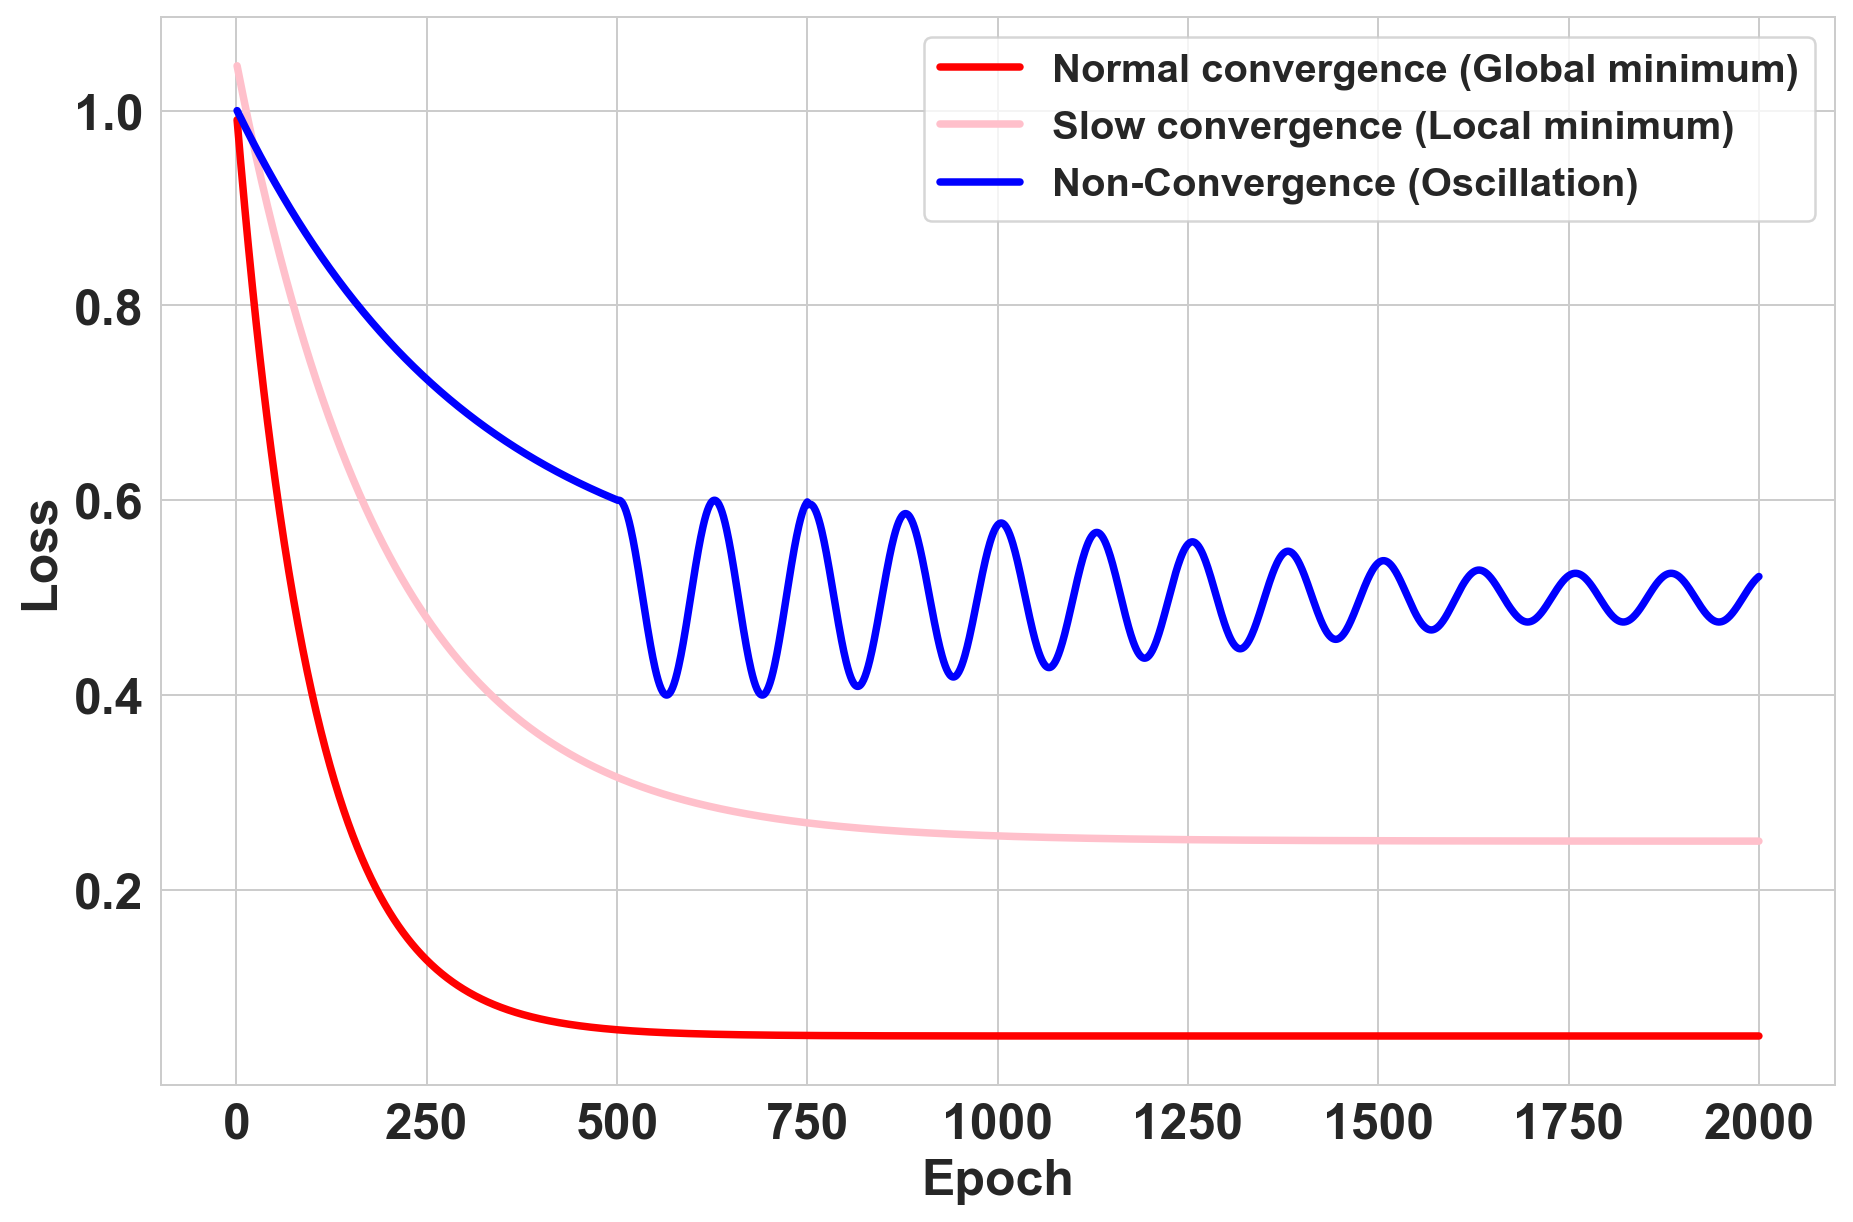

In [233]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, 2001)  # epochs 1 to 2000

# 1) Normal convergence: from 1.0 to ~0.05 using a high decay rate.
#    Formula: loss = 0.05 + 0.95 * exp(-decay1 * epoch)
decay1 = 0.01  # Increased decay rate
loss1 = 0.05 + 0.95 * np.exp(-decay1 * epochs)

# 2) Slow convergence: from 1.0 to ~0.3 using a small decay rate.
#    Formula: loss = 0.3 + 0.7 * exp(-decay2 * epoch)
decay2 = 0.005  # Much smaller decay rate
loss2 = 0.25 + 0.8 * np.exp(-decay2 * epochs)

# 3) Non-convergence: from 1.0 down to 0.4 by epoch ~500, then oscillates between 0.4 and 0.6.
loss3 = np.zeros(2000)

# --- Phase 1: Exponential decay from 1.0 to 0.6 for epochs 0 to 500 ---
# We use the formula: loss = 0.5 + 0.5 * exp(-decay3 * epoch)
# Choose decay3 so that at epoch 500: 0.5 + 0.5*exp(-decay3*500) = 0.6.
# That is: 0.5*exp(-decay3*500) = 0.1  => exp(-decay3*500) = 0.2  => decay3 = -ln(0.2)/500.
decay3 = -np.log(0.2) / 500
for i in range(500):
    loss3[i] = 0.5 + 0.5 * np.exp(-decay3 * i)
# At i=500, loss3[500] becomes:
loss3[500] = 0.5 + 0.5 * np.exp(-decay3 * 500)  # should be ~0.6

# --- Phase 2: Oscillatory behaviour from epochs 501 to 2000 ---
# Let t = i - 500, so t goes from 1 to 1500.
# We want:
#   - At t = 0, the function would ideally be 0.6 (already set at i=500).
#   - At t = 1 (epoch 501), we want loss3 ≈ 0.5. 
#     That means the oscillatory term should be nearly zero at t=1.
# We set the oscillation as:
#    loss3[i] = 0.5 + A(t) * sin(0.05 * t)
# where A(t) is the oscillation amplitude.
# For t in [0, 1300), let A(t)=0.1 (constant),
# and for t in [1300, 1500], let A(t) decay linearly from 0.1 to 0.
for i in range(501, 2000):
    t = i - 500
    if t < 250:
        A = 0.1
    else:
        A = max(0.1 * (1500 - t) / 1300, 0.025)  # Linear decay: at t=1500, A = 0.
    # With phase shift: we choose no additional phase shift,
    # so that sin(0.05 * 1) is small: sin(0.05) ≈ 0.05, yielding loss3[501] ≈ 0.5 + 0.1*0.05 = 0.505.
    loss3[i] = 0.5 + A * np.sin(1.5+ 0.05 * t)


# Plot all three curves
fig,ax=plt.subplots(1,1, figsize=(12, 7.7))
ax.plot(epochs, loss1, label='Normal convergence (Global minimum)', c='red',linewidth=3)
ax.plot(epochs, loss2, label='Slow convergence (Local minimum)',c='pink', linewidth=3)
ax.plot(epochs, loss3, label='Non-Convergence (Oscillation)', c='blue',linewidth=3)

ax.set_xlabel('Epoch', fontweight=fw, fontsize=fs)
ax.set_ylabel('Loss', fontweight=fw, fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
# ax.title('Three Different Loss Curves Over 2000 Epochs')
ax.grid(True)
ax.legend(prop={'weight':fw, 'size':fs-4})
fig.savefig(f'{FIGPATH}convergences.png', dpi=300, bbox_inches='tight')

In [256]:
n=9
k=3
math.ceil(n/k)

3

3

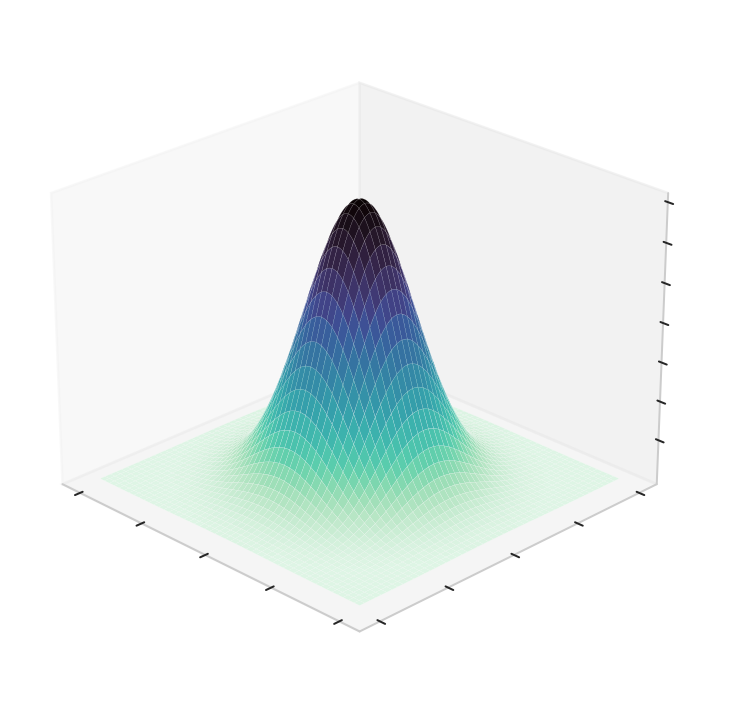

In [295]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = 0
variance_x = 9

mu_y = 0
variance_y = 9

#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')

ax.plot_surface(X, Y, rv.pdf(pos),cmap='mako_r',linewidth=0.05)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=25, azim=135)
ax.grid(visible=False)


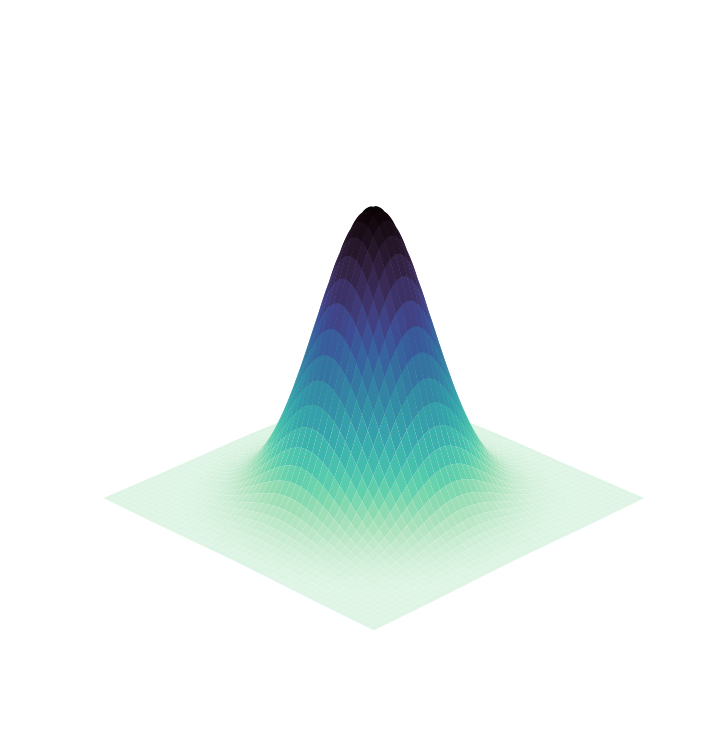

In [302]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters to set
mu_x = 0
variance_x = 9
mu_y = 0
variance_y = 9
sns.set_style('whitegrid')
# Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

# Make a 3D plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

# Plot the surface
surf = ax.plot_surface(
    X, Y, rv.pdf(pos),
    cmap='mako_r',
    linewidth=0.1,
    edgecolor='none'
)

# Remove all axis labels, ticks, grid lines, and background panes
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Hide the 3D panes and axis lines
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.zaxis.set_visible(False)

# Turn off the entire 3D bounding box
ax._axis3don = False

# Optionally set a specific view angle
ax.view_init(elev=25, azim=135)
fig.savefig(f'{FIGPATH}distribution.png', dpi=300, bbox_inches='tight')
plt.show()

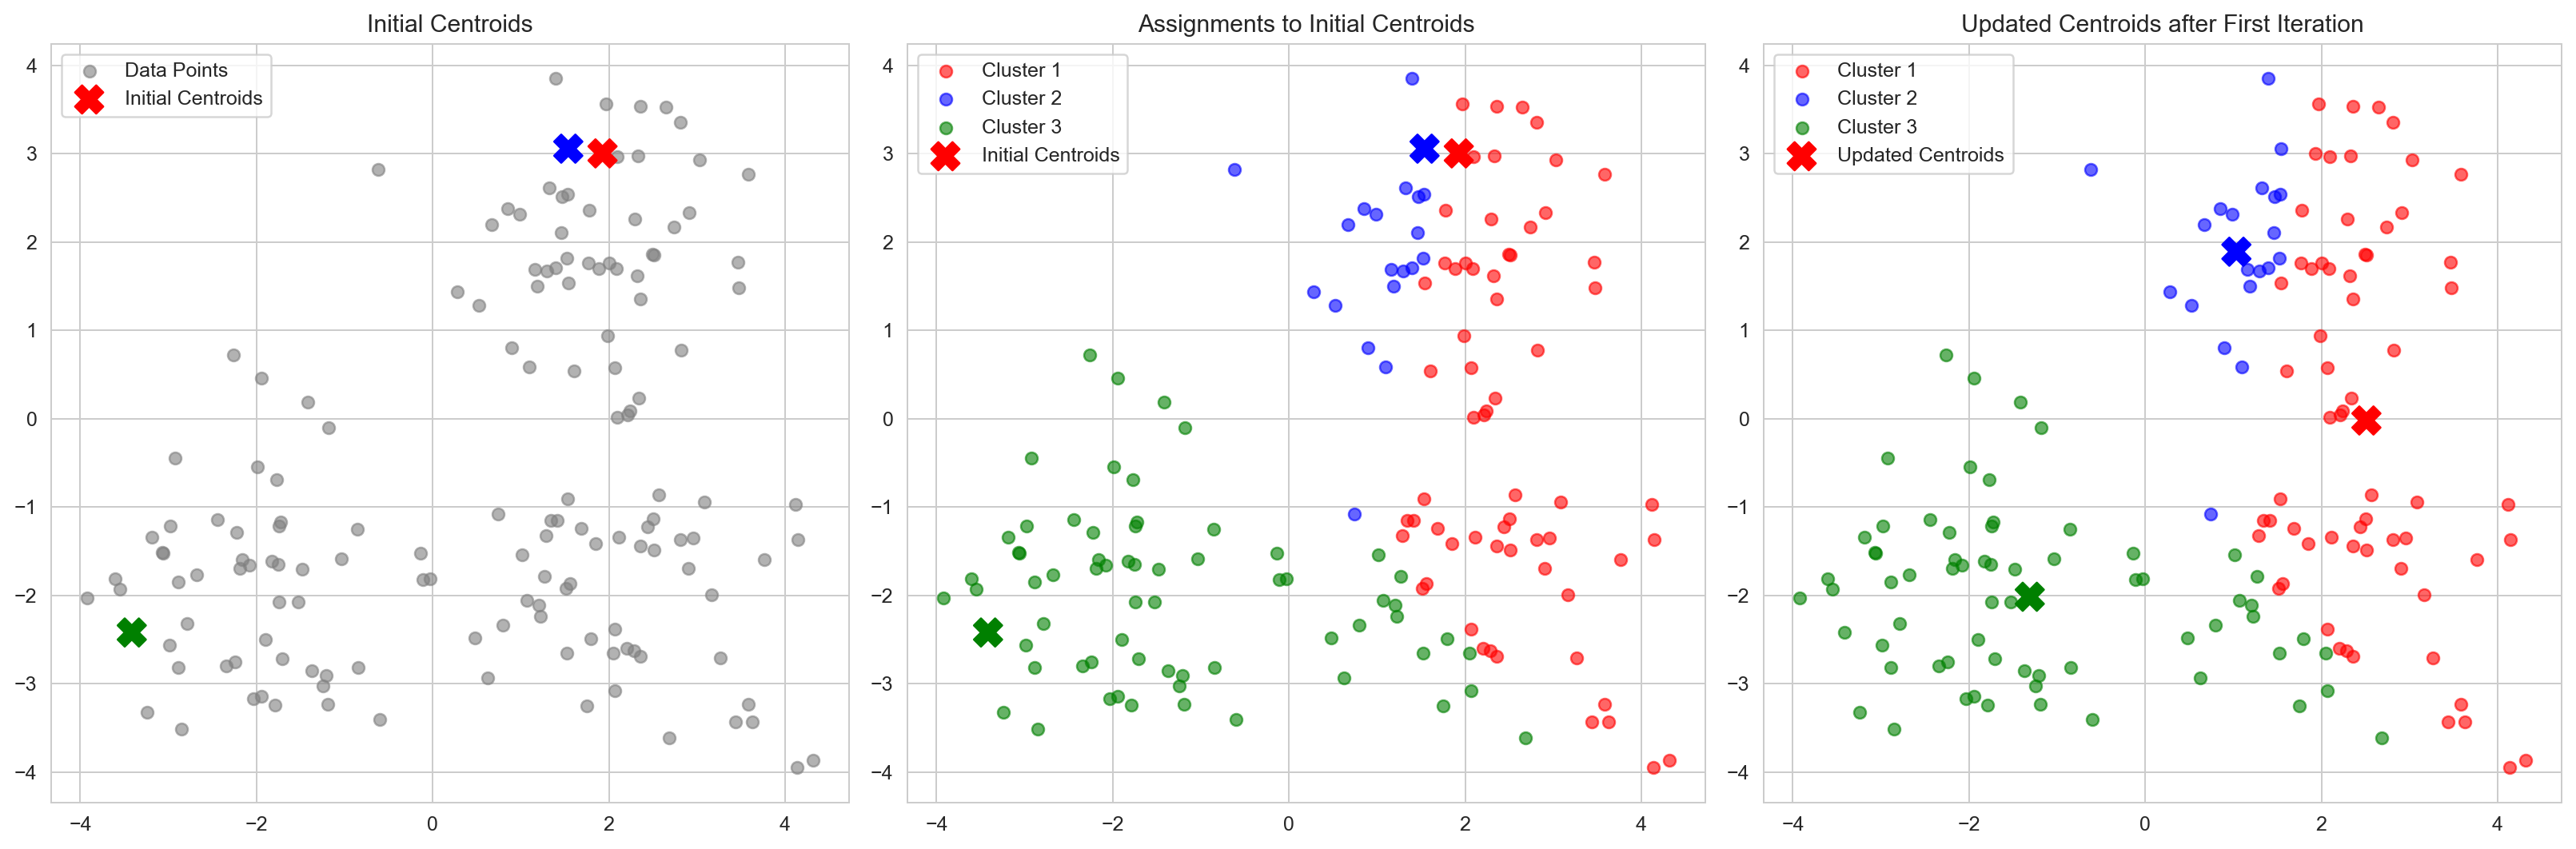

In [304]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data: three clusters for demonstration
np.random.seed(42)
cluster1 = np.random.randn(50, 2) + np.array([2, 2])
cluster2 = np.random.randn(50, 2) + np.array([-2, -2])
cluster3 = np.random.randn(50, 2) + np.array([2, -2])
data = np.vstack([cluster1, cluster2, cluster3])

# Randomly initialize 3 centroids from the data points
initial_indices = np.random.choice(data.shape[0], 3, replace=False)
centroids_initial = data[initial_indices]

# Function to compute Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# Assign each data point to the closest centroid (first iteration)
assignments = np.zeros(data.shape[0])
for i, point in enumerate(data):
    distances = np.array([euclidean_distance(point, centroid) for centroid in centroids_initial])
    assignments[i] = np.argmin(distances)

# Update centroids: compute the mean of points assigned to each centroid
centroids_updated = np.array([data[assignments == j].mean(axis=0) for j in range(3)])

# Define colors for the clusters
colors = ['red', 'blue', 'green']

# Create subplots to illustrate the steps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Initial Centroids
axes[0].scatter(data[:, 0], data[:, 1], c='gray', alpha=0.6, label='Data Points')
axes[0].scatter(centroids_initial[:, 0], centroids_initial[:, 1],
                c=colors, marker='X', s=200, label='Initial Centroids')
axes[0].set_title('Initial Centroids')
axes[0].legend()

# Subplot 2: Assignments to Initial Centroids
for j in range(3):
    axes[1].scatter(data[assignments == j, 0], data[assignments == j, 1],
                    c=colors[j], alpha=0.6, label=f'Cluster {j+1}')
axes[1].scatter(centroids_initial[:, 0], centroids_initial[:, 1],
                c=colors, marker='X', s=200, label='Initial Centroids')
axes[1].set_title('Assignments to Initial Centroids')
axes[1].legend()

# Subplot 3: Updated Centroids after First Iteration
for j in range(3):
    axes[2].scatter(data[assignments == j, 0], data[assignments == j, 1],
                    c=colors[j], alpha=0.6, label=f'Cluster {j+1}')
axes[2].scatter(centroids_updated[:, 0], centroids_updated[:, 1],
                c=colors, marker='X', s=200, label='Updated Centroids')
axes[2].set_title('Updated Centroids after First Iteration')
axes[2].legend()

plt.tight_layout()
plt.show()

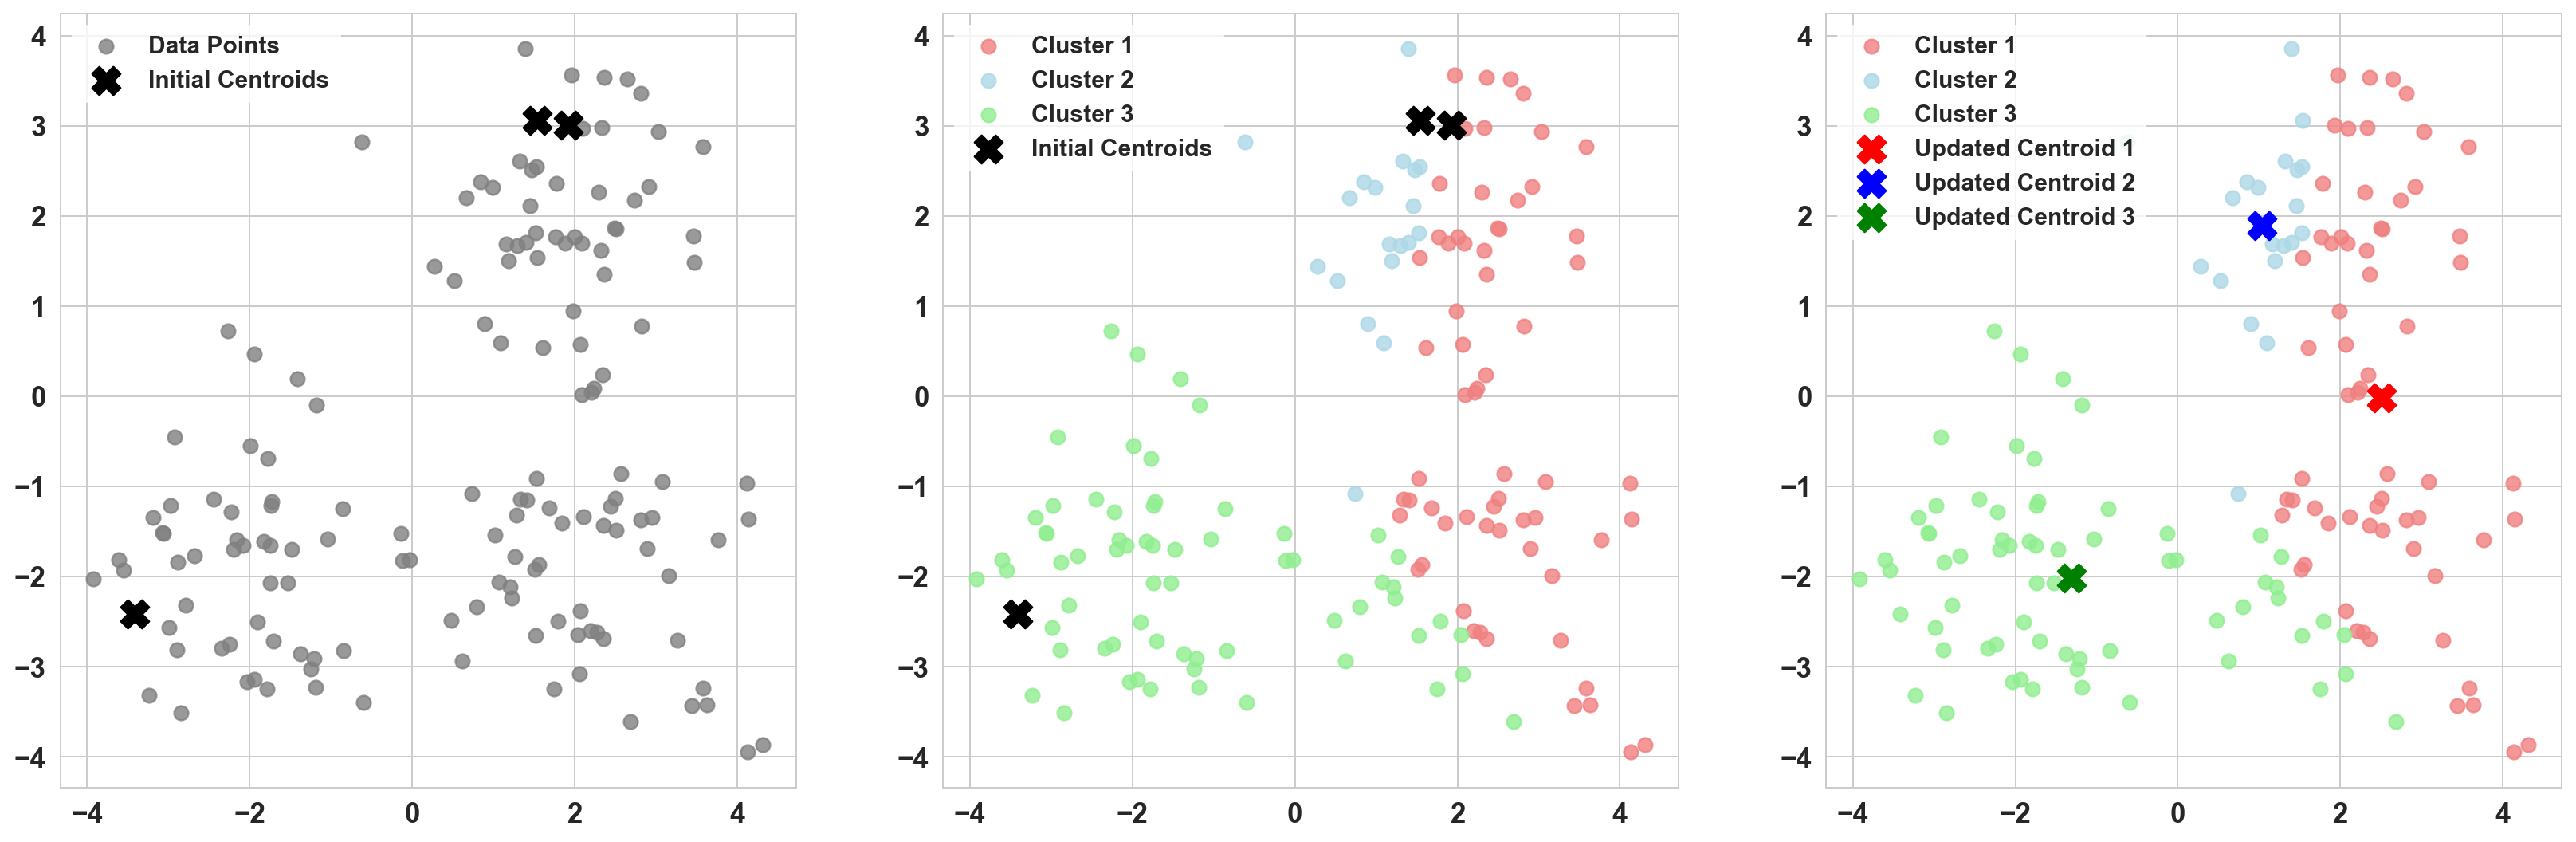

In [318]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data: three clusters for demonstration
np.random.seed(42)
cluster1 = np.random.randn(50, 2) + np.array([2, 2])
cluster2 = np.random.randn(50, 2) + np.array([-2, -2])
cluster3 = np.random.randn(50, 2) + np.array([2, -2])
data = np.vstack([cluster1, cluster2, cluster3])

# Randomly initialize 3 centroids from the data points
initial_indices = np.random.choice(data.shape[0], 3, replace=False)
centroids_initial = data[initial_indices]

# Function to compute Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# Assign each data point to the closest centroid (first iteration)
assignments = np.zeros(data.shape[0], dtype=int)
for i, point in enumerate(data):
    distances = [euclidean_distance(point, c) for c in centroids_initial]
    assignments[i] = np.argmin(distances)

# Update centroids: compute the mean of points assigned to each centroid
centroids_updated = np.array([data[assignments == j].mean(axis=0) for j in range(3)])

# Define colours for the clusters
cluster_colors = ['lightcoral', 'lightblue', 'lightgreen']
updated_centroid_colors = ['red', 'blue', 'green']  # distinct, darker colours for updated centroids

fig, axes = plt.subplots(1, 3, figsize=(22.5, 7))

# --- Subplot 1: Initial Centroids ---
axes[0].scatter(data[:, 0], data[:, 1], c='gray', alpha=0.8, s=50, label='Data Points')
axes[0].scatter(centroids_initial[:, 0], centroids_initial[:, 1],
                c='black', marker='X', s=200, label='Initial Centroids')
axes[0].set_title('Initial Centroids')
axes[0].legend(prop={'weight':'semibold', 'size':12}, edgecolor='w')

# --- Subplot 2: Assignments to Initial Centroids ---
for j in range(3):
    axes[1].scatter(data[assignments == j, 0], data[assignments == j, 1],
                    c=cluster_colors[j], alpha=0.8, s=50, label=f'Cluster {j+1}')
axes[1].scatter(centroids_initial[:, 0], centroids_initial[:, 1],
                c='black', marker='X', s=200, label='Initial Centroids')
axes[1].set_title('Assignments to Initial Centroids')
axes[1].legend(prop={'weight':'semibold', 'size':12}, edgecolor='w')

# --- Subplot 3: Updated Centroids (each with a unique colour) ---
for j in range(3):
    # Plot data points for cluster j
    axes[2].scatter(data[assignments == j, 0], data[assignments == j, 1],
                    c=cluster_colors[j], alpha=0.8, s=50, label=f'Cluster {j+1}')

# Plot each updated centroid in its own colour and label
for j in range(3):
    axes[2].scatter(centroids_updated[j, 0], centroids_updated[j, 1],
                    c=updated_centroid_colors[j], marker='X', s=200,
                    label=f'Updated Centroid {j+1}')

axes[2].set_title('Updated Centroids after First Iteration')
axes[2].legend(prop={'weight':'semibold', 'size':12}, edgecolor='w')

axes[0].set_xticklabels(axes[0].get_xticklabels(), fontweight='semibold', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontweight='semibold', fontsize=14)
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontweight='semibold', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontweight='semibold', fontsize=14)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontweight='semibold', fontsize=14)
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontweight='semibold', fontsize=14)
axes[0].set_title(None)
axes[1].set_title(None)
axes[2].set_title(None)
# fig.tight_layout()
fig.savefig(f'{FIGPATH}Kmeans_clusters.png', dpi = 300, bbox_inches='tight')